In [ ]:
import numpy as np
import pandas as pd
import warnings
import os
import math
import datetime as dt


# Libraries used for Evalutaion

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler


# Libraries used for model building

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM


# Libraries used For PLotting

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns


**LOADING THE DATASET**





In [81]:
import yfinance as yf
data=yf.download('BTC-USD')

[*********************100%%**********************]  1 of 1 completed


In [80]:
data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3560,2024-06-16,66189.359375,66894.843750,66018.250000,66639.046875,66639.046875,13281140541
3561,2024-06-17,66636.515625,67188.320313,65094.964844,66490.296875,66490.296875,30006354476
3562,2024-06-18,66490.976563,66556.703125,64066.957031,65140.746094,65140.746094,39481285950
3563,2024-06-19,65146.660156,65695.351563,64693.300781,64960.296875,64960.296875,21103423504
3564,2024-06-20,64960.296875,66390.328125,64838.554688,65949.632813,65949.632813,20448983040


In [ ]:
data.shape

(3565, 7)

*JUST A QUICK GO THROUGH THE DATASET*

In [3]:
data.info()
# We need to convert data type of Date Column into Datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565 entries, 0 to 3564
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3565 non-null   object 
 1   Open       3565 non-null   float64
 2   High       3565 non-null   float64
 3   Low        3565 non-null   float64
 4   Close      3565 non-null   float64
 5   Adj Close  3565 non-null   float64
 6   Volume     3565 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 195.1+ KB


In [4]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3565 entries, 0 to 3564
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3565 non-null   datetime64[ns]
 1   Open       3565 non-null   float64       
 2   High       3565 non-null   float64       
 3   Low        3565 non-null   float64       
 4   Close      3565 non-null   float64       
 5   Adj Close  3565 non-null   float64       
 6   Volume     3565 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 195.1 KB


In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3565.000000,3565.000000,3565.000000,3565.000000,3565.000000,3.565000e+03
mean,16732.901517,17117.345725,16323.117725,16750.058128,16750.058128,1.729242e+10
std,18624.028134,19050.937406,18156.635591,18638.081427,18638.081427,1.920015e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,1046.079956,1064.650024,1027.729980,1047.150024,1047.150024,2.432950e+08
50%,8812.489258,9008.314453,8645.024414,8820.522461,8820.522461,1.324991e+10
75%,27514.873047,28089.337891,27070.849609,27583.677734,27583.677734,2.788918e+10
max,73079.375000,73750.070313,71334.093750,73083.500000,73083.500000,3.509679e+11


In [ ]:
# Checking Null Values
data.isnull().sum().to_frame()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


**EXPLORATORY DATA ANALYSIS (EDA)**

In [9]:
#fig = px.bar(data, x='Date', y=['Close', 'Adj Close'])
#fig.show()

fig = px.line(data, x='Date', y=['Close', 'Adj Close'])
fig.update_layout(
    plot_bgcolor='white',  # Set plot background to white
    xaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='rgb(245, 245, 245)'  # Very light grey
    ),
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='rgb(245, 245, 245)'
    )
)
fig.show()

*WE CAN SEE FROM THE ABOVE GRAPH THAT CLOSE AND ADJUSTED CLOSE ARE ALMOST SIMILAR SO WE CAN USE EITHER OF THE COLUMN FOR PREDICTING BITCOIN PRICE*

In [10]:
fig = px.bar(data, x='Date', y=['Low', 'High'])
fig.show()

In [ ]:
# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Close", "Adj Close", "High", "Low"))

# Add traces for each subplot
fig.add_trace(go.Scatter(x=data['Date'], y=data['Close']), row=1, col=1)
fig.add_trace(go.Scatter(x=data['Date'], y=data['Adj Close']), row=1, col=2)
fig.add_trace(go.Scatter(x=data['Date'], y=data['High']), row=2, col=1)
fig.add_trace(go.Scatter(x=data['Date'], y=data['Low']), row=2, col=2)

# Update layout
fig.update_layout(height=600, width=800, title_text="Subplots for Close, Adj Close, High, and Low")

# Show the plot
fig.show()

*These Subplots give various information related to price of Bitcoin starting from september 2014 to March 2024*

1. The Difference Between Closing And Adjusted Closing price of bitcoin is almost similar.
2. Highest ever price of Bitcoin in 2024 is 73k,wheras lowest price is 338 USD in the year 2014





In [4]:
def combine_open_close(data):


    # Extract year and month from the 'Date' column
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month

    # Filter data for years between 2014 and 2024
    filtered_data = data[(data['Year'] >= 2015) & (data['Year'] <= 2024)]

    # Group the filtered data by year and month, and aggregate 'Open' and 'Close'
    combined_data = filtered_data.groupby(['Year', 'Month'])[['Open', 'Close']].mean().reset_index()

    return combined_data

In [6]:
combine_open_close(data).tail(12)

,Year,Month,Open,Close
102,2023,7,30098.767578,30057.469947
103,2023,8,27959.756615,27852.792843
104,2023,9,26271.268229,26306.136393
105,2023,10,29511.811114,29755.895161
106,2023,11,36491.666667,36596.164844
107,2023,12,42401.449849,42546.893523
108,2024,1,42910.015373,42919.612399
109,2024,2,49231.727101,49875.174300
110,2024,3,67372.752394,67702.439264
111,2024,4,66239.900912,65882.380599


In [5]:
def combine_by_month_name(data):


    # Extract month name from the 'Date' column
    data['Year'] = data['Date'].dt.year
    data['MonthName'] = data['Date'].dt.strftime('%B')

    #Filter data
    filtered_data = data[(data['Year'] >= 2015) & (data['Year'] <= 2024)]

    # Group the data by month name and aggregate 'Open' and 'Close'
    combined_data = filtered_data.groupby(['Year','MonthName'])[['Open', 'Close']].mean().reset_index()

    return combined_data

In [10]:
combine_by_month_name(data)

,Year,MonthName,Open,Close
0,2015,April,235.708667,235.491534
1,2015,August,252.986774,250.733805
2,2015,December,422.618033,424.464547
3,2015,February,232.821856,234.153645
4,2015,January,251.799905,248.782547
...,...,...,...,...
109,2024,February,49231.727101,49875.174300
110,2024,January,42910.015373,42919.612399
111,2024,June,67984.269727,67909.571680
112,2024,March,67372.752394,67702.439264


In [6]:
import plotly.express as px

def combine_open_close(data):
    # Extract year and month from the 'Date' column
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month

    # Filter data for years between 2014 and 2024
    filtered_data = data[(data['Year'] >= 2015) & (data['Year'] <= 2024)]

    # Group the filtered data by year and month, and aggregate 'Open' and 'Close'
    combined_data = filtered_data.groupby(['Year', 'Month'])[['Open', 'Close','High','Low']].mean().reset_index()

    return combined_data

# Assuming 'data' is already defined as in your notebook
combined = combine_open_close(data)

# Create a line plot for each year
fig = px.line(combined, x='Month', y='Close', color='Year', title='Bitcoin Closing Price by Year')
fig.show()

fig = px.line(combined, x='Month', y='Open', color='Year', title='Bitcoin Opening Price by Year')
fig.show()

In [13]:
combined.shape

(114, 6)

In [15]:
combined

,Year,Month,Open,Close,High,Low
0,2015,1,251.799905,248.782547,261.391583,240.495550
1,2015,2,232.821856,234.153645,240.211430,227.769678
2,2015,3,269.278419,269.042259,274.850999,263.134162
3,2015,4,235.708667,235.491534,238.957098,231.734033
4,2015,5,237.161806,236.997001,239.563161,234.939388
...,...,...,...,...,...,...
109,2024,2,49231.727101,49875.174300,50420.515221,48654.760776
110,2024,3,67372.752394,67702.439264,69272.725933,65532.276714
111,2024,4,66239.900912,65882.380599,67428.237761,64181.766276
112,2024,5,65044.212198,65266.317289,66383.555948,63922.288307


**ANALYSIS OF YEAR 2021**



1.   *We are considering only 1 year of data to predict Bitcoin Price.*
2.   *As the price of Bitcoin rise from 394 USD in the year 2014 to 19k USD in the year 2018 similarly it was 14k in the year 2022 and rise to 71k in 2024.*
3.   *Therefore we are considering the year 2021 for predicting the bitcoin price as the year 2021 has seen every type of fluctuation.*
4.   *We are using DATE & CLOSE column for predicting the Bitcoin Price.*





In [5]:
data['Date']=pd.to_datetime(data['Date'],format='%Y-%m-%d')

year_2021=data.loc[(data['Date']>='2021-01-01') &
                  ( data['Date']<='2021-12-31')]
year_2021.drop(year_2021[['Adj Close','Volume']],axis=1)


,Date,Open,High,Low,Close
2298,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344
2299,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578
2300,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438
2301,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063
2302,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688
...,...,...,...,...,...
2658,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969
2659,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469
2660,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938
2661,2021-12-30,46490.605469,47879.964844,46060.312500,47178.125000


In [6]:
month_name=year_2021.groupby(year_2021['Date'].dt.strftime('%B'))[['Open','Close']].mean()

In [8]:
month_name.head(12)

,Open,Close
Date,,
April,57251.256250,57206.720052
August,45516.119834,45709.022682
December,49670.411794,49263.209174
February,45874.967216,46306.798968
January,34652.961694,34761.649950
July,34234.212450,34444.973790
June,35920.546940,35845.154688
March,54544.678176,54998.008695
May,47105.828503,46443.286668


In [7]:
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
             'September', 'October', 'November', 'December']
month_name=month_name.reindex(new_order,axis=0)

month_name.head(12)

,Open,Close
Date,,
January,34652.961694,34761.649950
February,45874.967216,46306.798968
March,54544.678176,54998.008695
April,57251.256250,57206.720052
May,47105.828503,46443.286668
June,35920.546940,35845.154688
July,34234.212450,34444.973790
August,45516.119834,45709.022682
September,46041.859375,45939.771484


In [17]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=month_name.index,
    y=month_name['Open'],
    name='Bitcoin Open Price',
    marker_color='lightpink'
))
fig.add_trace(go.Bar(
    x=month_name.index,
    y=month_name['Close'],
    name='Bitcoin Close Price',
    marker_color=' turquoise'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45,
                  title='Monthwise comparision between Stock open and close price')

fig.show()

In [18]:
month_high=year_2021.groupby(year_2021['Date'].dt.strftime('%B'))['High'].max()
month_high=month_high.reindex(new_order,axis=0)

month_low=year_2021.groupby(year_2021['Date'].dt.strftime('%B'))['Low'].min()
month_low=month_low.reindex(new_order,axis=0)


fig=go.Figure()
fig.add_trace(go.Bar(
    x=month_high.index,
    y=month_high,
    name='Bitcoin Highest Price by month',
    marker_color='magenta'
))
fig.add_trace(go.Bar(
    x=month_low.index,
    y=month_low,
    name='Bitcoin Lowest Price by month',
    marker_color='orange'
))
fig.update_layout(barmode='group',
                  title=' Monthwise High and Low Bitcoin price of Year 2021')
fig.show()

In [19]:
names = cycle(['Bitcoin Open Price','Bitcoin Close Price','Bitcoin High Price','Bitcoin Low Price'])

fig = px.line(year_2021, x=year_2021.Date, y=[year_2021['Open'], year_2021['Close'],
                                          year_2021['High'], year_2021['Low']],
             labels={'Date': 'Date','value':'Bitcoin value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Bitcoin Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

**BUILDING LSTM MODEL**



1.   We will select the year 2021.
2.   Now we wil Normalize our data using minmax scaler(MinMaxScaler preserves the shape of the original distribution).
3.   



In [8]:
new_data=year_2021[['Date','Close']]

In [9]:
print("Total Data For Prediction ->",new_data.shape[0])

Total Data For Prediction -> 365


In [22]:
fig = px.line(new_data, x=new_data.Date, y=new_data.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Bitcoin close price',
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [10]:
#Normalizing The Data
scaler=MinMaxScaler(feature_range=(0,1))
new_data1=scaler.fit_transform(np.array(new_data['Close']).reshape(-1,1))

In [11]:
new_data1.shape

(365, 1)

In [37]:
# We are keeping the Training Set as 70% and testing set 30%
train_size=int(len(new_data1)*0.70)
test_size=len(new_data1)-train_size
train_data,test_data=new_data1[0:train_size,:],new_data1[train_size:len(new_data1),:1]

In [38]:
train_size,test_size

(255, 110)

In [25]:
test_data.shape

(128, 1)

In [39]:
# in time series data to predict output of next day ,we need how many previous days to depend upon
# it is decided by setting timesteps,like timesteps = 10 means we are depending upon previous 10 days to predict O/P of next day
# and then including the O/P the next 9 days would be considered to predict O/P and so on
def create_dataset(dataset,timestep=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-timestep-1):
    a=dataset[i:(i+timestep),0]  # i=0 0,1,2,3-----14 -> 15 will be appended and then 1,2---15
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)

In [40]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (239, 15)
y_train:  (239,)
X_test:  (94, 15)
y_test (94,)


In [41]:
X_test.shape

(94, 15)

In [42]:
#reshaping -> lstm layers in keras expect i/p in 3D format(samples,timesteps,features) reshaping ensures our
# I/P data is compatible with the lstm layer
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (239, 15, 1)
X_test:  (94, 15, 1)


**ACTUAL TRAINING OF THE MODEL**

In [49]:
model=Sequential()
model.add(LSTM(100,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(100,return_sequences=True)) # Add another LSTM layer
model.add(LSTM(100)) # Final LSTM layer without return_sequences
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 15, 100)           40800     
                                                                 
 lstm_10 (LSTM)              (None, 15, 100)           80400     
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 201701 (787.89 KB)
Trainable params: 201701 (787.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
8/8 [==============================] - 8s 223ms/step - loss: 0.0943 - val_loss: 0.0151
Epoch 2/200
8/8 [==============================] - 0s 41ms/step - loss: 0.0259 - val_loss: 0.0214
Epoch 3/200
8/8 [==============================] - 0s 43ms/step - loss: 0.0199 - val_loss: 0.0211
Epoch 4/200
8/8 [==============================] - 0s 52ms/step - loss: 0.0168 - val_loss: 0.0139
Epoch 5/200
8/8 [==============================] - 0s 44ms/step - loss: 0.0170 - val_loss: 0.0259
Epoch 6/200
8/8 [==============================] - 0s 43ms/step - loss: 0.0174 - val_loss: 0.0135
Epoch 7/200
8/8 [==============================] - 0s 49ms/step - loss: 0.0168 - val_loss: 0.0125
Epoch 8/200
8/8 [==============================] - 0s 43ms/step - loss: 0.0147 - val_loss: 0.0165
Epoch 9/200
8/8 [==============================] - 0s 42ms/step - loss: 0.0135 - val_loss: 0.0112
Epoch 10/200
8/8 [==============================] - 0s 50ms/step - loss: 0.0133 - val_loss: 0.0103
Epoch 11/200
8/8 [

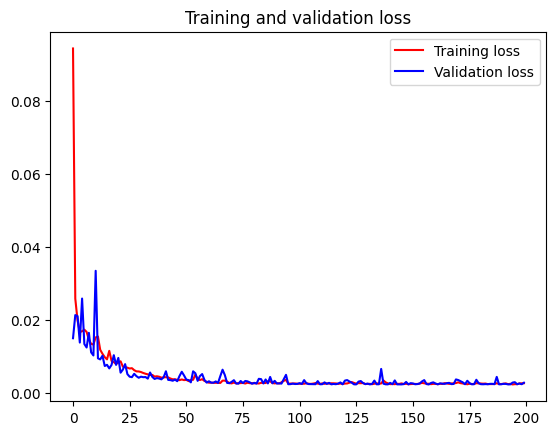

<Figure size 640x480 with 0 Axes>

In [51]:
### Plotting Loss v/s Validation Loss
import matplotlib.pyplot as plt

loss = history.history['loss']   ## Training data loss
val_loss = history.history['val_loss']   ## Test loss

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [52]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 14ms/step


((239, 1), (94, 1))

In [53]:
## Model Evaluation -> Transfromin normalize values into original values for better prediction
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

**Evaluation Metrices**

In [54]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1894.9906652292818
Train data MSE:  3590989.621306116
Train data MAE:  1421.9349013017784
-------------------------------------------------------------------------------------
Test data RMSE:  2054.1996922387007
Test data MSE:  4219736.375593572
Test data MAE:  1622.2444731170203


In [55]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9592474982823089
Test data R2 score: 0.9014785483336205


In [76]:
def calculate_mape(original_ytest, test_predict):
    original_ytest, test_predic = np.array(original_ytest), np.array(test_predict)
    return np.mean(np.abs((original_ytest - test_predict) / original_ytest)) * 100

In [77]:
mape=calculate_mape(original_ytest,test_predict)
print("MAPE for the Data is : ",mape,'%')

#Around 2.90% Mape(Mean absolute percentage error) which means model is 97.1% accurate in predicting the test set observations

MAPE for the Data is :  2.908075954275065 %


**Visualizing train and test data in order to get a summarized view**

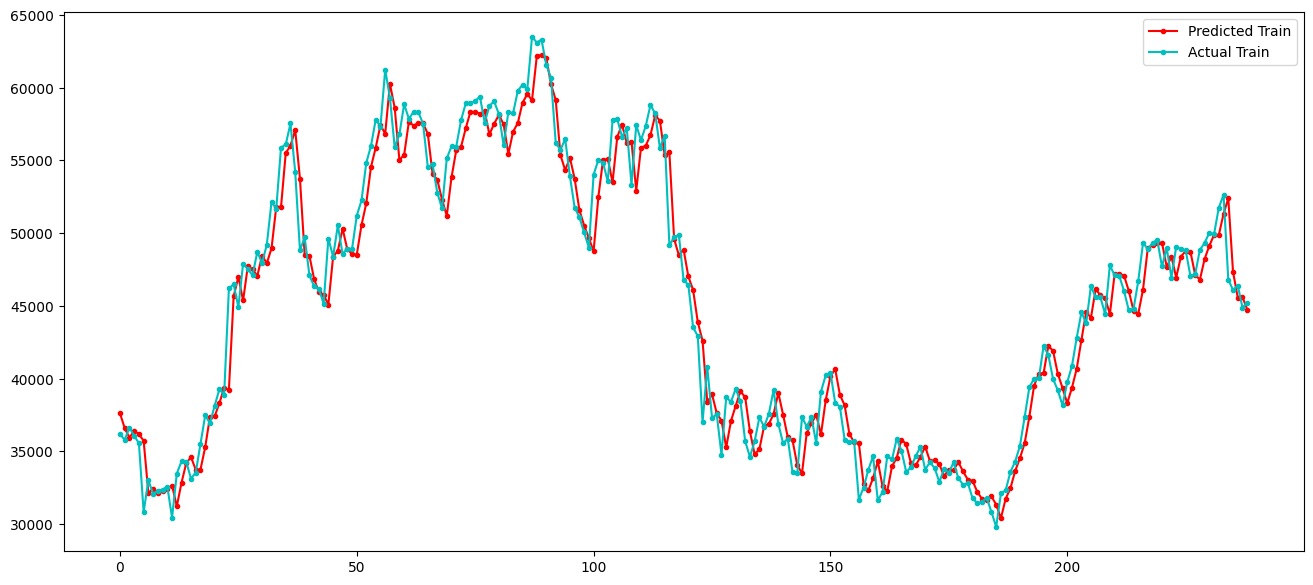

In [58]:
plt.figure(figsize=(16,7))

plt.plot(train_predict, 'r', marker='.', label='Predicted Train')

plt.plot(original_ytrain,'c', marker='.', label='Actual Train')

plt.legend()
plt.show()

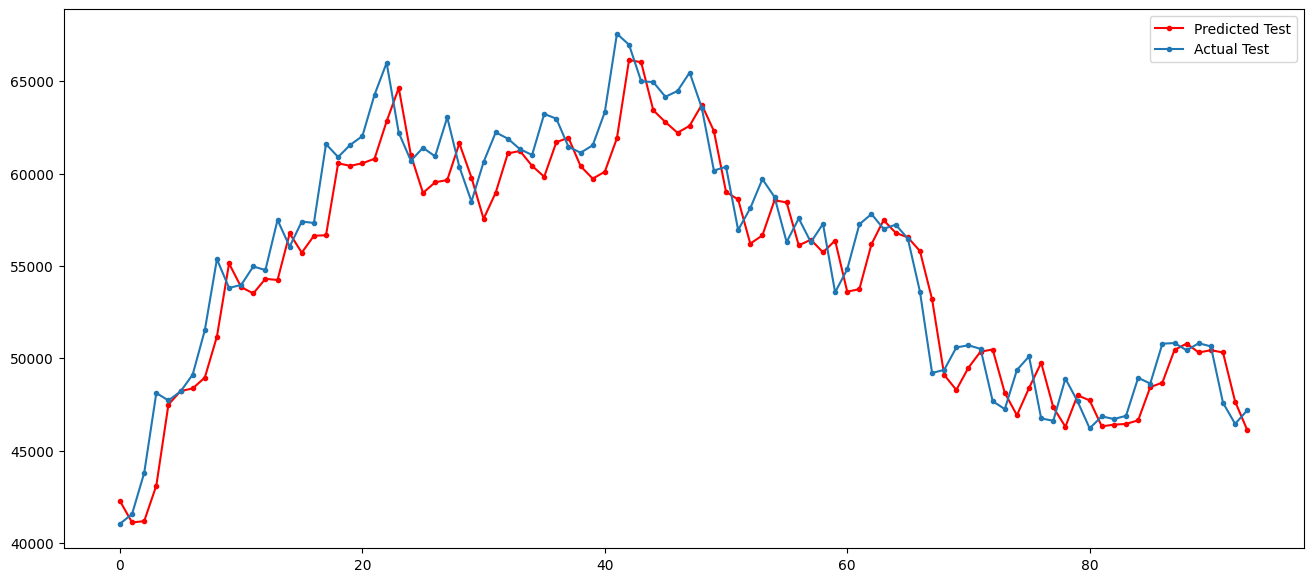

In [59]:
plt.figure(figsize=(16,7))

plt.plot(test_predict, 'r', marker='.', label='Predicted Test')

plt.plot(original_ytest, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [70]:
len(test_data)

110

In [69]:
##  Predicting Next 30 days

x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", lst_output)

1 day input [0.45753864 0.45382689 0.45836341 0.51220451 0.50413748 0.56058881
 0.56157477 0.55130222 0.56124277 0.55681528 0.47691613 0.44695896
 0.46616196 0.44333875 0.43886855]
1 day output [[0.43366438]]
[0.4575386417071422, 0.4538268902757191, 0.4583634071721393, 0.5122045140061092, 0.5041374813696248, 0.5605888113671048, 0.5615747661144476, 0.5513022222306493, 0.5612427734551034, 0.5568152843477779, 0.4769161299261836, 0.44695895862033896, 0.46616196147369904, 0.4433387455252201, 0.43886855244636536, 0.43366438150405884]
2 day input [0.45382689 0.45836341 0.51220451 0.50413748 0.56058881 0.56157477
 0.55130222 0.56124277 0.55681528 0.47691613 0.44695896 0.46616196
 0.44333875 0.43886855 0.43366438]
2 day output [[0.42912176]]
[0.4538268902757191, 0.4583634071721393, 0.5122045140061092, 0.5041374813696248, 0.5605888113671048, 0.5615747661144476, 0.5513022222306493, 0.5612427734551034, 0.5568152843477779, 0.4769161299261836, 0.44695895862033896, 0.46616196147369904, 0.443338745525

In [68]:
len(temp_input)

16

In [67]:
x_input

array([[[0.37840468],
        [0.37486759],
        [0.37141609],
        [0.36804473],
        [0.36475143],
        [0.36153507],
        [0.35839477],
        [0.35532981],
        [0.35233873],
        [0.34941986],
        [0.34657139],
        [0.34379166],
        [0.34107909],
        [0.3384321 ],
        [0.33584946]]])

In [66]:
lst_output

[[0.43886855244636536],
 [0.43366438150405884],
 [0.4291217625141144],
 [0.42477649450302124],
 [0.42036741971969604],
 [0.41586658358573914],
 [0.4112492799758911],
 [0.4066570997238159],
 [0.4021465480327606],
 [0.39776715636253357],
 [0.39358457922935486],
 [0.38962504267692566],
 [0.3857765793800354],
 [0.38202357292175293],
 [0.3784046769142151],
 [0.37486758828163147],
 [0.3714160919189453],
 [0.36804473400115967],
 [0.3647514283657074],
 [0.36153507232666016],
 [0.3583947718143463],
 [0.35532981157302856],
 [0.3523387312889099],
 [0.34941986203193665],
 [0.3465713858604431],
 [0.343791663646698],
 [0.34107908606529236],
 [0.33843210339546204],
 [0.33584946393966675],
 [0.33332985639572144]]

In [61]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [62]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(new_data1[len(new_data1)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,

    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [74]:
len(next_predicted_days_value),len(last_original_days_value)

(46, 46)

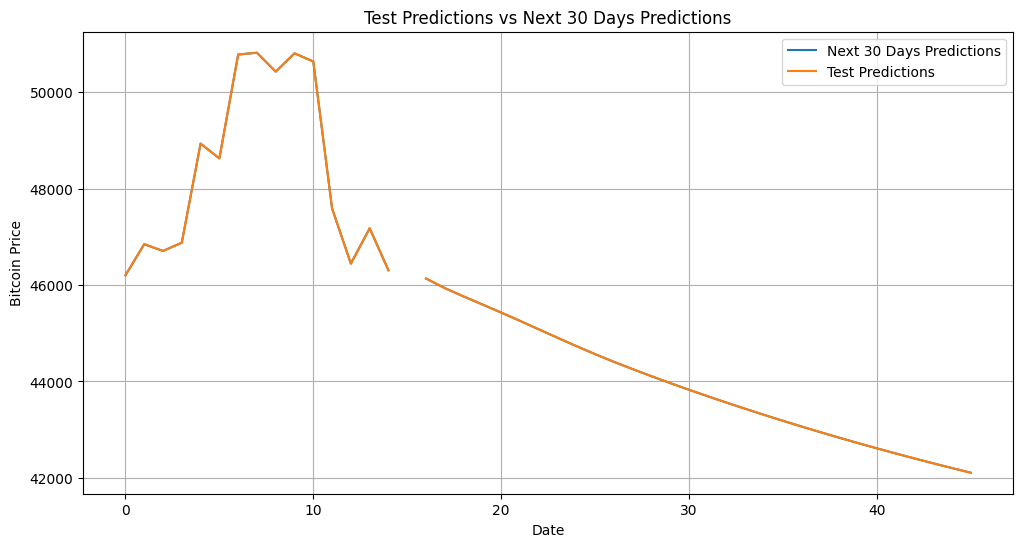

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(next_predicted_days_value, label='Next 30 Days Predictions')
plt.plot(last_original_days_value, label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.title('Test Predictions vs Next 30 Days Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [65]:
lstmdf=new_data1.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()